# Science with `deeplenstronomy`!

The notebooks up until this point have demonstrated the features of `deeplenstronomy` at their most basic level. This notebook will show how I would design a science-ready training set by putting some of those features to use.

We'll be going through the configuration file `example.yaml`, which simulates a 4-class dataset consisting of galaxy-galay lensing, galaxy-galaxy lensing where the lens is a real DES galaxy, lensed quasars, and a galaxy by itself.

In [1]:
import deeplenstronomy.deeplenstronomy as dl
from deeplenstronomy.visualize import view_image, view_image_rgb

### Top Level Dataset Properties

Like in the other examples, we start by selecting the size of our dataset and telling `deeplenstronomy` where to save the images at the end of the day.

In [2]:
! head -11 data/example.yaml

# A full example of using deeplenstronomy.
# The science goal here will be the detection of galaxy-galaxy lensing and lensed quasars.
# This file will contain all the information needed to describe the dataset.

## We start at the top level with the DATASET section

DATASET:
    NAME: ExampleDataset # set a name, this value is only used if you request the h5 file format
    PARAMETERS:
        SIZE: 1000 # number of images in the full dataset, I'll keep it small for this example
        OUTDIR: ExampleDataset # will be created on your system if your request to save images


Next up is the cosmology section. Here I could also specify $T_{cmb}$, $N_{eff}$, and other parameters of the `astropy.cosmology.FlatLambdaCDM` class, but we can get away with just specifying $H_0$ and $\Omega_m$ since that is technically all that is needed for the cosmology calculation performed internally.

In [3]:
! head -19 data/example.yaml | tail -7

## Next we'll specify the COSMOLOGY to use, I'll keep it simple a just use basic values

COSMOLOGY:
    PARAMETERS:
        H0: 74.0
        Om0: 0.3



### Camera and Observing Conditions

Now normally we would write the `IMAGE` and `SURVEY` sections next to describe the camera and observing conditions, but I will make use of `deeplenstronomy`'s built-in surveys functionality and just pass `survey='des'` when calling the `deeplenstronomy.make_dataset()` function.

In [4]:
! head -22 data/example.yaml | tail -4


## Next we technically need the IMAGE and SURVEY sections, but I will get around this using a built-in survey mode
## by specifying survey='des' in deeplenstronomy.make_dataset(), these sections will be automatically written



### Describing the Objects to Simulate

Time to describe the objects we want to put in our dataset. Onward to the `SPECIES` section!

I'll start with a galaxy. It's name will be "SimulatedLens" and I'll use this name to refer to it later on. I'll add to this galaxy a "Light Profile" to describe how it's light will appear and a "Mass Profile" to tell `deeplenstronomy` how it will affect the light of objects behind it.

For the Light Profile, I'm choosing to call the `lenstronomy` "SERSIC_ELLIPSE" model, then I set its parameters:

- I'll be giving this galaxy realistic color later on, so I'm going to put a fake value in for the `magnitude`
- `center_x` and `center_y` are set to 0 so that this object is always in the exact center of the image;
- The 4 other parameters are all drawn from distributions of physically-motivated values to give the simulated galaxies diversity

For the Mass Profile, I'm choosing to call the `lenstronomy` "SIE" model, then I set its parameters:

- I draw `theta_E`, `e1`, and `e2` from realistic distributions;
- `center_x` and `center_y` are set to 0 for the same reason as the Light Profile

In [5]:
! head -83 data/example.yaml | tail -58

SPECIES:
    GALAXY_1:  # This will be the first type of lens galaxy, and it's properties will by fully simulated
        NAME: SimulatedLens # name of this galaxy object
        LIGHT_PROFILE_1: # we'll describe how the light of this galaxy looks
            NAME: SERSIC_ELLIPSE # a good default lenstronomy light model
            PARAMETERS:
                magnitude: -5 # I'm setting this to a non-real value because I will overwrite it with a USERDIST later
                center_x: 0.0 # set the lens galaxy to be at the center of the images
                center_y: 0.0
                R_sersic: # controls the angular size of the galaxy
                    DISTRIBUTION: # draw from a distribution to give the dataset diversity
                        NAME: normal  # use a normal distribution around 6
                        PARAMETERS:
                            mean: 6.0
                            std: 1.5
                n_sersic: # controls the slope of the light profile
      

Next, I'll write the properties for the galaxy I plan to use as a source galaxy in the gravitational lensing systems. I'll name it "SimulatedSource". I'll use a similar Light Profile, and I can get away without a Mass Profile because the source galaxy's mass will not affect the lensing.

The parameters will be defined in a similar way to the Light Profile of SimulatedLens, but this time I will draw `center_x` and `center_y` from narrow distributions to account for not-exactly-alligned gravitational lensing.

In [6]:
! head -126 data/example.yaml | tail -42

    GALAXY_2: # now we'll do a source galaxy, and no need for a mass profile since only the light matters in the lensing
        NAME: SimulatedSource
        LIGHT_PROFILE_1:
            NAME: SERSIC_ELLIPSE
            PARAMETERS:
                magnitude: -5 # again, we'll overwrite this value with a USERDIST
                center_x:
                    DISTRIBUTION: #draw source position from a distribution to allow for small misalignments
                        NAME: normal
                        PARAMETERS:
                            mean: 0.0
                            std: 0.5
                center_y:
                    DISTRIBUTION: #draw source position from a distribution to allow for small misalignments
                        NAME: normal
                        PARAMETERS:
                            mean: 0.0
                            std: 0.5
                R_sersic: # controls the angular size of the galaxy
                    DISTRIBUTION: # draw from a dis

To finish off the galaxies I'll define in this configuration file, I will make a third galaxy called "DarkLens". The reason for the name is I am going to simulate **no light at all** coming from this galaxy, and then I am going to use a real DES image of a lens galaxy in its place.

The Light Profile here is very simple because I'm intending it to be meaningless. I set the magnitude to 100 so that the light will be several dozens of orders of magnitude too faint to detect, and then I add values to all the other parameters to satisfy both `deeplenstronomy` and `lenstronomy`.

The Mass Profile here is important. To make the training dataset realistic, I want to make sure the the real image of a galaxy that I use has its properties encoded into the lensing calculations. Specifically, I will use the measured velocity dispersion of the DES galaxy in each image in the simulation. Thus, I am specifying `sigma_v` instead of `theta_E` in this case.

- It's important when using `deeplenstronomy`'s `BACKGROUNDS` functionality to draw the parameters you are associating with the images from distributions. Internally, this is not a straightforward overwriting. Rather, the distribution is sampled first, and then the image with the closest velocity dispersion to each drawn value is utilized.

In [7]:
! head -163 data/example.yaml | tail -36

    GALAXY_3: # I'll use this galaxy as a completely dark object so that a real image of a lens galaxy can be used
        NAME: DarkLens
        LIGHT_PROFILE_1:
            NAME: SERSIC_ELLIPSE
            PARAMETERS:
                magnitude: 100 # so that the light is essentially zero
                center_x: 0.0 # doesn't matter, just need a valid number
                center_y: 0.0 # doesn't matter, just need a valid number
                R_sersic: 1.0 # doesn't matter, just need a valid number
                n_sersic: 1.0 # doesn't matter, just need a valid number
                e1: 0.5 # doesn't matter, just need a valid number
                e2: 0.5 # doesn't matter, just need a valid number
        MASS_PROFILE_1:
            NAME: SIE
            PARAMETERS:
                sigma_v: # velocity dispersion of the lens galaxy, this will be linked to the lens galaxy image used
                    DISTRIBUTION:
                        NAME: uniform
                        

Closing out the `SPECIES` section, I'll include a quasar so that we can simulated lensed quasars along with the other cases of galaxy-galaxy lensing.

I'll name this object "Quasar" and specify that I want the `POINTSOURCE` to be located within the galaxy that I named SimulatedSource earlier. Since a quasar is always at the center of a galaxy, I will leave off the `sep`, `sep_unit` and `angle` parameters, in which case `deeplenstronomy` will place the `POINTSOURCE` at the center of its `HOST`. Lastly, I'll plan to overwrite the magnitude with a realistic, color-dependent, distribution using `deeplenstronomy`'s `USERDIST` functionality.

In [8]:
! head -171 data/example.yaml | tail -8

    
    POINTSOURCE_1: # add a point source for a quasar
        NAME: Quasar
        HOST: SimulatedSource # put the quasar in the simulated source galaxy
        PARAMETERS: # no need for sep, angle, or sep_unit parameters since the point source will be at the center of the host
            magnitude: -5 # We'll overwrite this with a realistic quasar color distribution as a USERDIST
        



### Object Placements

Now I'll fill in the `GEOMETRY` section to tell `deeplenstronomy` how I want the objects oriented. Let's start with a straightforward galaxy-galaxy lensing system. Each system I choose to create will be called a `CONFIGURATION`. I've named this one "GalaxyGalaxySimulated" so I can keep track that I'm doing galaxy-galaxy lensing and using all simulated light. I also specify `FRACTION: 0.25` so that this type of system will make up 1/4 of the total images that get produced.

Because I want to put one galaxy behind another one, I need two `PLANE`s, in each plane I write the name of the objects I want and I set the redshift.

In [9]:
! head -228 data/example.yaml | tail -25

## Lastly, we'll specify how we want the GEOMETRY of the systems simulated

GEOMETRY:
    CONFIGURATION_1: 
        NAME: GalaxyGalaxySimulated # describe what's in this configuration
        FRACTION: 0.25 # images from this configuration will make up 1/4 of the dataset
        PLANE_1: # add all objects in the first plane
            OBJECT_1: SimulatedLens # name of the object to put in this plane
            PARAMETERS:
                REDSHIFT:
                    DISTRIBUTION:
                        NAME: uniform
                        PARAMETERS:
                            minimum: 0.05
                            maximum: 0.3
        PLANE_2: # add all objects in the second plane
            OBJECT_1: SimulatedSource
            PARAMETERS:
                REDSHIFT:
                    DISTRIBUTION:
                        NAME: uniform
                        PARAMETERS:
                            minimum: 0.5
                            maximum: 1.0



Next let's put in a second configuration where I keep everything the same, except I'll switch out "SimulatedLens" for "DarkLens". This will be the configuration where I put in the real DES images later on. This one I'll name "GalaxyGalaxyReal" to indicate the use of real images while still doing galax-galaxy lensing.

In [10]:
! head -250 data/example.yaml | tail -22

    CONFIGURATION_2:
        NAME: GalaxyGalaxyReal # describe what's in this configuration
        FRACTION: 0.25 # images from this configuration will make up 1/4 of the dataset
        PLANE_1: # add all objects in the first plane
            OBJECT_1: DarkLens # name of the object to put in this plane
            PARAMETERS:
                REDSHIFT:
                    DISTRIBUTION:
                        NAME: uniform
                        PARAMETERS:
                            minimum: 0.05
                            maximum: 0.3
        PLANE_2: # add all objects in the second plane
            OBJECT_1: SimulatedSource
            PARAMETERS:
                REDSHIFT:
                    DISTRIBUTION:
                        NAME: uniform
                        PARAMETERS:
                            minimum: 0.5
                            maximum: 1.0



Next let's make the dataset a little more fun and put in a lensed quasar system. I'll call this configuration "GalaxyQuasarSimulated". Everything is the same as `CONFIGURATION_1`, but I have added `OBJECT_2: Quasar` to `PLANE_2`. This line tells `deeplenstronomy` to include the object in it the `SPECIES` section named "Quasar". Recall that "Quasar" has a `HOST` of "SimulatedSource", so `deeplenstronomy` is already prepared to put this object in that galaxy.

In [11]:
! head -272 data/example.yaml | tail -22

    CONFIGURATION_3:
        NAME: GalaxyQuasarSimulated # describe what's in this configuration
        FRACTION: 0.25 # images from this configuration will make up 1/4 of the dataset
        PLANE_1: # add all objects in the first plane
            OBJECT_1: SimulatedLens # name of the object to put in this plane
            PARAMETERS:
                REDSHIFT:
                    DISTRIBUTION:
                        NAME: uniform
                        PARAMETERS:
                            minimum: 0.05
                            maximum: 0.3
        PLANE_2: # add all objects in the second plane
            OBJECT_1: SimulatedSource
            OBJECT_2: Quasar # now we add the quasar on top of the source galaxy
            PARAMETERS:
                REDSHIFT:
                    DISTRIBUTION:
                        NAME: uniform
                        PARAMETERS:
                            minimum: 0.5
                            maximum: 1.0


Lastly, I'll include a configuration where I only simulate a single galaxy. The motivation here is to simulate a background class for a neural network to train on. Presumably the largest background you'll face will be individual galaxies, but you can get as detailed as you want. To make "JustAGalaxy" I will copy `CONFIGURATION_1`, but I will remove the second plane that contained the background galaxy.

In [12]:
! head -285 data/example.yaml | tail -12

    CONFIGURATION_4:
        NAME: JustAGalaxy # describe what's in this configuration
        FRACTION: 0.25 # images from this configuration will make up 1/4 of the dataset
        PLANE_1: # add all objects in the first plane
            OBJECT_1: SimulatedLens # name of the object to put in this plane
            PARAMETERS:
                REDSHIFT:
                    DISTRIBUTION:
                        NAME: uniform
                        PARAMETERS:
                            minimum: 0.05
                            maximum: 0.3


### Including the real galaxy images

Recall that in `CONFIGURATION_2` I've utilized the object we aptly named "DarkLens" and that we effectively gave this object zero apparent luminosity. The reasoning here is that we wanted to have a mass profile, but utilize the light from a real image. To do that, I'll use the `BACKGROUNDS` feature of `deeplenstronomy`.

In [13]:
! head -203 data/example.yaml | tail -6

## Now we'll point toward the background images we want to use, which contain DES galaxies at z < 0.3

BACKGROUNDS: 
    PATH: data/example_background_images
    CONFIGURATIONS: ['CONFIGURATION_2']



The `CONFIGURATIONS` argument is a list containing only `CONFIGURATION_2` which specifies that I only want these background images to be utilized for `CONFIGURATION_2`.

In [14]:
! ls data/example_background_images

Y.fits  g.fits  i.fits  map.txt r.fits  z.fits


I've supplied a directory `example_background_images` of 46 DES images of galaxies (and the galaxies also overlap with SDSS) split into each band that I'm simulating in this dataset. I also give a `map.txt` file, which tells `deeplenstronomy` the properties of the galaxies in the images.

In [15]:
! head data/example_background_images/map.txt

CONFIGURATION_2-PLANE_1-OBJECT_1-MASS_PROFILE_1-sigma_v-g CONFIGURATION_2-PLANE_1-OBJECT_1-MASS_PROFILE_1-sigma_v-r CONFIGURATION_2-PLANE_1-OBJECT_1-MASS_PROFILE_1-sigma_v-i CONFIGURATION_2-PLANE_1-OBJECT_1-MASS_PROFILE_1-sigma_v-z CONFIGURATION_2-PLANE_1-OBJECT_1-MASS_PROFILE_1-sigma_v-Y
196.737 196.737 196.737 196.737 196.737
255.839 255.839 255.839 255.839 255.839
211.848 211.848 211.848 211.848 211.848
241.311 241.311 241.311 241.311 241.311
193.026 193.026 193.026 193.026 193.026
241.299 241.299 241.299 241.299 241.299
183.588 183.588 183.588 183.588 183.588
271.999 271.999 271.999 271.999 271.999
235.621 235.621 235.621 235.621 235.621


Each of the galaxies here have a measure velocity dispersion, so in the `map.txt` file I am telling `deeplenstronomy` about the velocity dispersion of each galaxy (each galaxy is one row and the rows are aligned with the index of the image in the FITS files). 

Then, with the header row, I am telling `deeplenstronomy` which properties these velocity dispersions map to in the simualtions. Since the configuration with "DarkLens" is `CONFIGURATION_2` and "DarkLens" is `OBJECT_1` in `PLANE_1`, and since the velocity dispersion is characterized by the `sigma_v` parameter of "DarkLens"'s `MASS_PROFILE_1`, we can create a header string of:

`CONFIGURATION_2-PLANE_1-OBJECT_1-MASS_PROFILE_1-sigma_v-`

and finally since the velocity dispersion is not a color-dependent quantity, we make the velocity dispersion the same for each band.

### Including Realistic Object Colors

In the same vein of simulating a dark galaxy knowing we would include real images, recall that we also left flag values of -5 in the `LIGHT_PROFILE_1-magnitude` parameter for "SimulatedLens", "SimulatedSource", and "Quasar". In this section we will finally give these objects physically meaningful brightnesses and colors.

I'll do this by utilizing `USERDIST`s. In total there are 7 `USERDIST`s that I am utilizing. For each one I specify it's filename and the mode I will be using. In this case I've chosen to use the `sample` mode, which draws from the raw points in the file rather than interpolate a grid of points. This mode is **much** more efficient when correlating more than a couple parameters.

In [16]:
! head -196 data/example.yaml | tail -23

DISTRIBUTIONS:
    USERDIST_1:
        FILENAME: data/low_z_galaxy_colors_config_1.txt  # contains redshift and g,r,i,z,y mag for DES galaxies at z < 0.3
        MODE: sample # sample from all the rows specified in the file
    USERDIST_2:
        FILENAME: data/low_z_galaxy_colors_config_3.txt  # redshift and g,r,i,z,y mag for DES galaxies at z<0.3
        MODE: sample # sample from all the rows specified in the file
    USERDIST_3:
        FILENAME: data/low_z_galaxy_colors_config_4.txt  # redshift and g,r,i,z,y mag for DES galaxies at z<0.3
        MODE: sample # sample from all the rows specified in the file
    USERDIST_4:
        FILENAME: data/quasar_colors.txt # contains fake quasar colors to make them blueish
        MODE: sample   
    USERDIST_5: 
        FILENAME: data/high_z_galaxy_colors_config_1.txt # redshift and g,r,i,z,y for DES galaxies at 0.5<z<1.0
        MODE: sample
    USERDIST_6: 
        FILENAME: data/high_z_galaxy_colors_config_2.txt # redshift and g,r,i,z,y

Let's start with the first 3 `USERDIST`s: filenames `low_z_galaxy_colors_config_*.txt`. These three files are identical with the exception of the header row, which I will cover next. The columns in the files weree produced with the following query:

```python
SELECT DNF_ZMEAN_SOF, MAG_PSF_G, MAG_PSF_R, MAG_PSF_I, MAG_PSF_Z, MAG_PSF_Y 
FROM Y3_GOLD_2_2 
WHERE EXTENDED_CLASS_COADD = 3 and DEC > -44 and DEC < -40 and DNF_ZMEAN_SOF < 0.3 and ROWNUM < 101;
```

Ignoring some of the DES-specific column and table names, what I've done is select the magnitude in each band and the redshift of 100 galaxies in a random patch of sky for low redshift galaxies. I've then put the query results directly into the `USERDIST` files with updated column names:

In [17]:
! head -5 data/low_z_galaxy_colors_config_1.txt

CONFIGURATION_1-PLANE_1-OBJECT_1-REDSHIFT CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-g CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-r CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-i CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-z CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-Y WEIGHT
0.12649094 19.87325859 19.09209251 18.70531082 18.48275948 18.42626953 1.0
0.25748792 21.79298973 21.43421555 21.26678276 21.34543800 21.33299065 1.0
0.21782839 21.72157860 21.09894562 20.83550835 20.69699860 20.75214195 1.0
0.17391822 22.20806122 21.85676384 21.70260429 21.67228889 21.56722069 1.0


The column names match how `deeplenstronomy` will track the object. It can take some getting used to. I've also added a `WEIGHT` column. These weights represent the frequency at which each row is used. They are defined relative to each other, so it's not necessary thaty they sum to one.

As I mentioned earlier, the only difference between `low_z_galaxy_colors_config_1.txt`, `low_z_galaxy_colors_config_3.txt`, and `low_z_galaxy_colors_config_4.txt` is the header row. In these other files `CONFIGURATION_1` has been replaced with `CONFIGURATION_3` and `CONFIGURATION_4` respectively. Thus, I am still using the same galaxy colors and redshfits, but I attributing it to different object in the simulation. These files are used for `CONFIGURATION_1`, `CONFIGURATION_3`, and `CONFIGURATION_4` because they target "SimulatedLens" in each case.

Similarly, the files `high_z_galaxy_colors_config_1.txt`, `high_z_galaxy_colors_config_2.txt`, and `high_z_galaxy_colors_config_3.txt` were produced with the query:

```python
SELECT DNF_ZMEAN_SOF, MAG_PSF_G, MAG_PSF_R, MAG_PSF_I, MAG_PSF_Z, MAG_PSF_Y 
FROM Y3_GOLD_2_2 
WHERE EXTENDED_CLASS_COADD = 3 and DEC > -44 and DEC < -40 and DNF_ZMEAN_SOF > 0.5 and ROWNUM < 101;
```

and these files target the redshift and magnitude of "SimulatedSource" everywhere it appears in the simulation.

Lastly, I use the file `quasar_colors.txt` to put in **fake** quasar colors where I have created the distribution of magnitudes to make the objects appear blue and to be bright at the redshifts they will be place at in the simulation. I would recommed using real AGN observations if you are working with lensed quasars.

In [18]:
! head data/quasar_colors.txt

CONFIGURATION_3-PLANE_2-OBJECT_2-magnitude-g CONFIGURATION_3-PLANE_2-OBJECT_2-magnitude-r CONFIGURATION_3-PLANE_2-OBJECT_2-magnitude-i CONFIGURATION_3-PLANE_2-OBJECT_2-magnitude-z CONFIGURATION_3-PLANE_2-OBJECT_2-magnitude-Y WEIGHT
21.88 22.04 22.35 22.52 22.55 0.05
21.93 22.32 22.33 22.34 22.35 0.05
21.88 22.21 22.28 22.31 22.70 0.05
21.40 21.61 21.66 21.75 21.76 0.05
21.40 21.62 22.01 22.08 22.48 0.05
21.96 22.06 22.30 22.49 22.71 0.05
21.51 21.70 22.05 22.18 22.37 0.05
21.51 21.58 21.97 22.29 22.45 0.05
21.68 21.95 22.07 22.39 22.68 0.05


### Summary

That is all the information in the file `example.yaml`. We have utilized built-in astronomical surveys, realistic galaxy colors, real images of galaxies, and physically motivated distributions of all parameters to give us a rich training set ready for a neural network. At this point, we're ready to call `deeplenstronomy.make_dataset()` and simualted our images.

### The Simulated Dataset

In [19]:
dataset = dl.make_dataset('data/example.yaml', survey='des', verbose=True)

Entering main organization loop
Organizing CONFIGURATION_1
Organizing CONFIGURATION_2
Organizing CONFIGURATION_3
Organizing CONFIGURATION_4
Generating images for CONFIGURATION_1
	Progress: 100.0 %  ---  Elapsed Time: 0 H 0 M 9 S
Generating images for CONFIGURATION_2
	Progress: 100.0 %  ---  Elapsed Time: 0 H 0 M 9 S
Generating images for CONFIGURATION_3
	Progress: 100.0 %  ---  Elapsed Time: 0 H 0 M 44 S
Generating images for CONFIGURATION_4
	Progress: 100.0 %  ---  Elapsed Time: 0 H 0 M 6 S


We can inspect the images using the `deeplenstronomy` visualization features.

Here's `CONFIGURATION_1`, which was galaxy-galaxy lensing with both the source and lens being simulated:

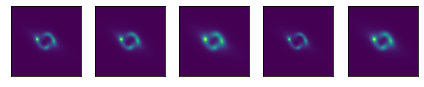

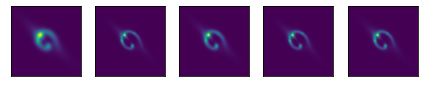

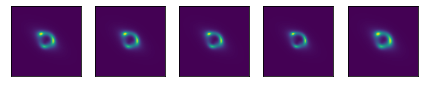

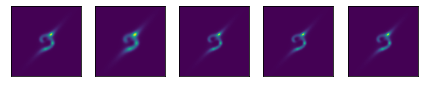

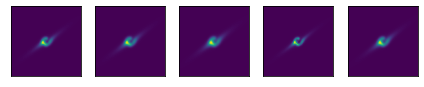

In [20]:
for i in range(5):
    view_image(dataset.CONFIGURATION_1_images[i])

All the metadata for these images is stored here:

In [21]:
dataset.CONFIGURATION_1_metadata.head()

,OBJID-g,H0-g,Om0-g,exposure_time-g,numPix-g,pixel_scale-g,psf_type-g,read_noise-g,ccd_gain-g,seeing-g,...,PLANE_1-REDSHIFT-g,PLANE_2-REDSHIFT-g,PLANE_1-REDSHIFT-r,PLANE_2-REDSHIFT-r,PLANE_1-REDSHIFT-i,PLANE_2-REDSHIFT-i,PLANE_1-REDSHIFT-z,PLANE_2-REDSHIFT-z,PLANE_1-REDSHIFT-Y,PLANE_2-REDSHIFT-Y
0,0,74.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,0.921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,74.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.719,...,0.165344,0.541347,0.165344,0.541347,0.165344,0.541347,0.165344,0.541347,0.165344,0.541347
2,2,74.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.040,...,0.237946,0.961559,0.237946,0.961559,0.237946,0.961559,0.237946,0.961559,0.237946,0.961559
3,3,74.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,0.902,...,0.195374,0.799212,0.195374,0.799212,0.195374,0.799212,0.195374,0.799212,0.195374,0.799212
4,4,74.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,0.962,...,0.254798,0.861982,0.254798,0.861982,0.254798,0.861982,0.254798,0.861982,0.254798,0.861982


Here's `CONFIGURATION_2` which was real DES images of the lens galaxy and a simulated source behind it:

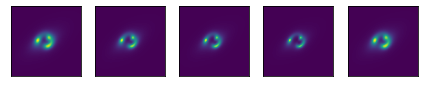

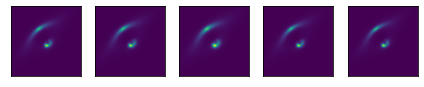

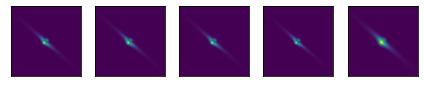

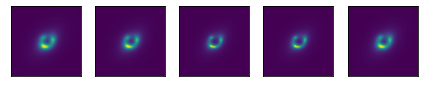

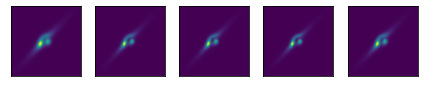

In [22]:
for i in range(5):
    view_image(dataset.CONFIGURATION_2_images[i])

Here is `CONFIGURATION_3` which was the same as `CONFIGURATION_1` but with a quasar in the source galaxy:

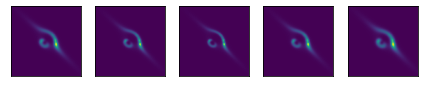

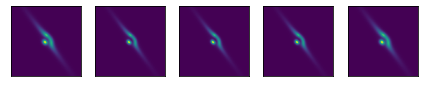

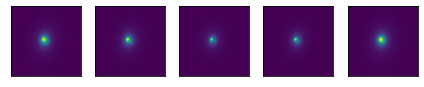

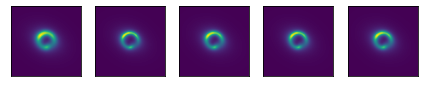

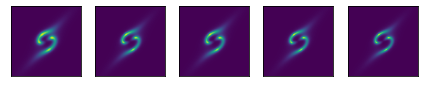

In [23]:
for i in range(5):
    view_image(dataset.CONFIGURATION_3_images[i])

And finally here is `CONFIGURATION_4` which is just a galaxy by itself.

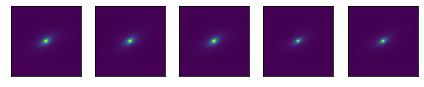

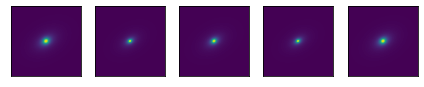

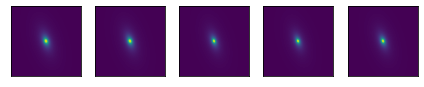

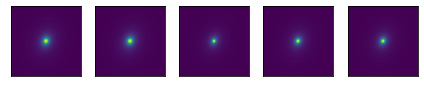

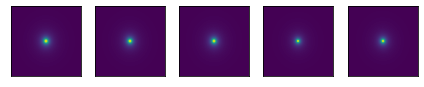

In [24]:
for i in range(5):
    view_image(dataset.CONFIGURATION_4_images[i])